In [265]:
# Import packages

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn import neighbors
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from scipy.stats import norm
from operator import itemgetter
from sklearn.model_selection import cross_val_score

In [266]:
dfHistorical = pd.read_csv(r'C:\Users\ricks\Documents\historical-data.csv')
dfCurrent = pd.read_csv(r'C:\Users\ricks\Documents\current-data.csv')

In [267]:
dfHistorical.head()

,Rank,Player,Age,Tm,Pts Won,Pts Max,Share,G,Team Wins,Overall Seed,...,3P%,FT%,WS,WS/48,VORP,BPM,G-Lockout,Wins-Lockout,WS-Lockout,VORP-Lockout
0,1,Kareem Abdul-Jabbar,32,LAL,147.0,221,0.665,82.0,60.0,2,...,0.000,0.765,14.8,0.227,6.8,6.7,NaN,NaN,NaN,NaN
1,2,Julius Erving,29,PHI,31.5,221,0.143,78.0,59.0,3,...,0.200,0.787,12.5,0.213,6.5,7.2,NaN,NaN,NaN,NaN
2,3,George Gervin,27,SAS,19.0,221,0.086,78.0,41.0,10,...,0.314,0.852,10.6,0.173,3.1,2.2,NaN,NaN,NaN,NaN
3,4,Larry Bird,23,BOS,15.0,221,0.068,82.0,61.0,1,...,0.406,0.836,11.2,0.182,5.4,5.3,NaN,NaN,NaN,NaN
4,5,Tiny Archibald,31,BOS,2.0,221,0.009,80.0,61.0,1,...,0.222,0.830,8.9,0.148,1.5,0.0,NaN,NaN,NaN,NaN


In [268]:
train, test = train_test_split(dfHistorical, test_size = 0.25, random_state = 10)

x_train = train[['Team Wins', 'Overall Seed', 'PTS', 'TRB', 'AST', 'FG%', 'VORP', 'WS']]
y_train = train[['Share']]

x_test = test[['Team Wins', 'Overall Seed', 'PTS', 'TRB', 'AST', 'FG%', 'VORP', 'WS']]
y_test = test[['Share']]

## MODELS (Support Vector, K-Nearest Neighbors, Neural Network)

In [269]:
svr = SVR(kernel = 'rbf', gamma = 1e-3, C = 100, epsilon = .1)
y_svr = []

scores(y_svr, svr)

Mean squared error: 0.027
R2 score: 0.710


In [270]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 7, weights = 'uniform')

y_knn = []
scores(y_knn, knn)

Mean squared error: 0.035
R2 score: 0.633


In [271]:
dnn = MLPRegressor(
    solver='lbfgs',
    hidden_layer_sizes=100,
    max_iter=10000,
    random_state=987654321,
    activation='identity',
    learning_rate ='invscaling')

y_dnn = []
scores(y_dnn, dnn)

Mean squared error: 0.036
R2 score: 0.619


### Score Function

The higher r^2 value and lower mean squared error value equates to more accurate models

In [272]:
# Accuracy check and fit models
def scores(y, model):
    
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    
    print("Mean squared error: %.3f" % mean_squared_error(y_test, y_pred))
    print('R2 score: %.3f' % r2_score(y_test, y_pred))

    
    for i in y_pred:
        y.append(i)

### Standard Residuals Test

A standardized residuals test analyzes the difference between the model's predicted and actual values on historical data. To pass the test, the models have at least 95% of their standardized residuals within 2 standard deviations of the mean and have no noticeable trend. Passing the standardized residuals test gives us a first indication that the models' errors are random.

In [273]:
#Create function that prepares the standardized residuals

def residuals(x, y):
    
    resid = [i for i in (y_test['Share'] - x)]
    ssr = [i ** 2 for i in resid]
    
    ssrSum = 0
    for i in ssr:
        ssrSum += i
        
    standResid = []
    for i in resid:
        standResid.append(i / ((ssrSum / (y_test.shape[0] - 2)) ** (1/2)))
    
    for i in standResid:
        y.append(i)

In [274]:
svrResid = []
knnResid = []
dnnResid = []

residuals(y_svr, svrResid)
residuals(y_knn, knnResid)
residuals(y_dnn, dnnResid)

In [275]:
def outliers(x):
    
    npList = np.array(x)
    stdev = np.std(npList)
    mean = np.mean(npList)

    outliers = 0
    for i in x:
        if i < mean - 2 * stdev:
            outliers += 1
        elif i > mean + 2 * stdev:
            outliers += 1

    outlierPercent = 1 - outliers / y_test.shape[0]
    outlierString = "{:.3%}".format(outlierPercent)
    
    return outlierString

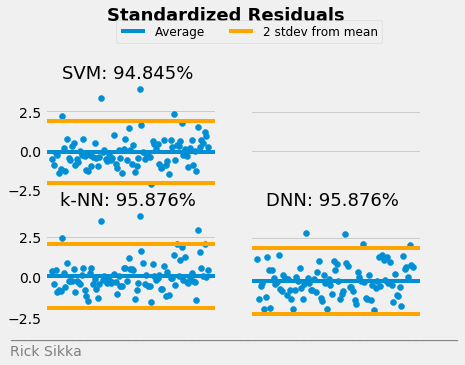

In [276]:
plt.style.use('fivethirtyeight')

residFig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey = 'row')

x = np.arange(y_test.shape[0])
ax1.xaxis.set_visible(False)
ax2.xaxis.set_visible(False)
ax3.xaxis.set_visible(False)
ax4.xaxis.set_visible(False)

ax1.scatter(x, svrResid)
ax1.axhline(y = np.mean(svrResid), label = "Average")
ax1.axhline(y = np.mean(svrResid) - 2 * np.std(svrResid), color = 'orange')
ax1.axhline(y = np.mean(svrResid) + 2 * np.std(svrResid), label = "2 stdev from mean", color = 'orange')
ax1.set_title("SVM: %s" % outliers(svrResid), size = 18, x = .485, ha = 'center')


ax3.scatter(x, knnResid)
ax3.axhline(y = np.mean(knnResid))
ax3.axhline(y = np.mean(knnResid) - 2 * np.std(knnResid), color = 'orange')
ax3.axhline(y = np.mean(knnResid) + 2 * np.std(knnResid), color = 'orange')
ax3.set_title("k-NN: %s" % outliers(knnResid), size = 18, x = .485, ha = 'center')

ax4.scatter(x, dnnResid)
ax4.axhline(y = np.mean(dnnResid))
ax4.axhline(y = np.mean(dnnResid) - 2 * np.std(dnnResid), color = 'orange')
ax4.axhline(y = np.mean(dnnResid) + 2 * np.std(dnnResid), color = 'orange')
ax4.set_title("DNN: %s" % outliers(dnnResid), size = 18, x = .485, ha = 'center')

residFig.legend(loc = (.25, .88), ncol=2, prop={'size': 12, "family": "Rockwell"})

residFig.suptitle("Standardized Residuals", weight = 'bold', size = 18, y = 1.15)

ax1.yaxis.set_ticks([-2.5, 0, 2.5])
ax3.yaxis.set_ticks([-2.5, 0, 2.5])

residFig.text(x = 0, y = 0,
    s = '________________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

residFig.text(x = 0, y = -.06,
    s = 'Rick Sikka                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')

residFig.savefig('resid-fig.png', dpi = 400, bbox_inches = 'tight')

### Durbin - Watson Test

In [277]:
from statsmodels.stats import stattools as stools

print(stools.durbin_watson(svrResid))
print(stools.durbin_watson(knnResid))
print(stools.durbin_watson(dnnResid))

1.836130305961713
1.8486335445324737
1.6866440343490032


### PREDICTIONS

In [278]:
dfCurrentNames = dfCurrent.iloc[:, 1]
dfCurrentPredict = dfCurrent[['Team Wins', 'Overall Seed', 'PTS', 'TRB', 'AST', 'FG%', 'VORP', 'WS']]
x = 5
dfCurrent.head()

,Rank,Player,Age,Tm,G,Team Wins,Overall Seed,MP,PTS,TRB,...,FT%,WS,WS/48,VORP,BPM,G-Unadjusted,Wins-Unadjusted,WS-Unadjusted,VORP-Unadjusted,Total Games
0,1,Giannis (1),24,MIL,76.142857,58.571429,2,33.5,26.7,12.6,...,0.701,13.861905,0.261,7.419048,9.6,39,30,7.1,3.8,42
1,2,Harden (2),29,HOU,76.142857,46.857143,11,37.2,34.2,6.2,...,0.859,13.471429,0.229,9.371429,11.2,39,24,6.9,4.8,42
2,3,Curry (3),30,GSW,61.023256,55.302326,4,34.6,29.4,5.2,...,0.917,9.725581,0.221,4.767442,7.1,32,29,5.1,2.5,43
3,4,Kawhi (4),27,TOR,63.777778,60.133333,1,34.9,27.5,8.0,...,0.846,10.933333,0.238,4.191111,5.6,35,33,6.0,2.3,45
4,5,Jokic (5),23,DEN,82.000000,56.619048,3,31.4,19.7,10.2,...,0.837,12.300000,0.228,7.614286,9.7,42,29,6.3,3.9,42


### Support Vector Regression

In [279]:
svrPredict = svr.predict(dfCurrentPredict)
svrPredict = svrPredict.tolist()

for (i, j) in zip(dfCurrentNames, svrPredict):
    print(i, j)

Giannis (1) 0.7022878946723233
Harden (2) 0.5467403682540558
Curry (3) 0.25611516514390986
Kawhi (4) 0.3140821895049152
Jokic (5) 0.38935054052582474
PG13 (6) 0.15965216175709374
Embiid (7) 0.20987036116811397
LeBron (8) 0.05577111821209202
KD (9) 0.2578586167364699
Davis (10) 0.2525827933784862


In [280]:
svrListUnsorted = [[i, j] for i, j in zip(dfCurrentNames, svrPredict)]
svrDataUnsorted = [row[1] for row in svrListUnsorted]
svrList = sorted(svrListUnsorted, key = itemgetter(1), reverse = True)

svrData = [row[1] for row in svrList]
svrNames = [row[0] for row in svrList]
print(svrList)

x_svr = np.arange(len(svrData))

[['Giannis (1)', 0.7022878946723233], ['Harden (2)', 0.5467403682540558], ['Jokic (5)', 0.38935054052582474], ['Kawhi (4)', 0.3140821895049152], ['KD (9)', 0.2578586167364699], ['Curry (3)', 0.25611516514390986], ['Davis (10)', 0.2525827933784862], ['Embiid (7)', 0.20987036116811397], ['PG13 (6)', 0.15965216175709374], ['LeBron (8)', 0.05577111821209202]]


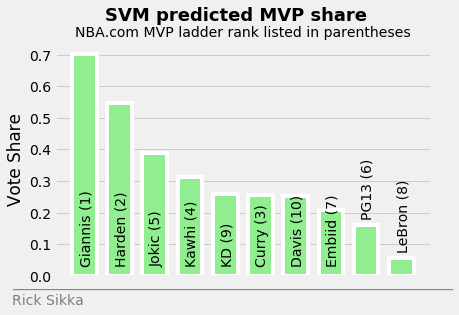

In [281]:
plt.style.use('fivethirtyeight')

svr, ax = plt.subplots()

ax.bar(x_svr, svrData, width = .7, edgecolor = 'white', color = 'lightgreen', linewidth = 4, label = 'Predicted')

labels = svrNames

rects = ax.patches
for rect, label in zip(rects, labels):
    if rect.get_x() > 7:
        ax.text(rect.get_x() + rect.get_width() / 1.75, rect.get_height() + .02, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
    elif rect.get_x() <=7:
        height = .03
        ax.text(rect.get_x() + rect.get_width() / 1.75, height, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
    
svr.suptitle("SVM predicted MVP share", weight = 'bold', size = 18, y = 1.005)
ax.set_title("NBA.com MVP ladder rank listed in parentheses", size = 14, fontname = 'Rockwell')
ax.xaxis.set_visible(False)
ax.set_ylabel("Vote Share")

svr.text(x = -0.02, y = 0.03,
    s = '_______________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

svr.text(x = -0.02, y = -.03,
    s = 'Rick Sikka',
    fontsize = 14, fontname = 'DejaVu Sans', color = 'grey', horizontalalignment='left')

svr.savefig('svr.png', dpi = 400, bbox_inches = 'tight')

### k-Nearest Neighbors

In [282]:
knnPredict = knn.predict(dfCurrentPredict)
knnPredict = knnPredict.tolist()

for (i, j) in zip(dfCurrentNames, knnPredict):
    print(i, j)

Giannis (1) 0.5315714285714286
Harden (2) 0.3862857142857143
Curry (3) 0.25614285714285717
Kawhi (4) 0.25042857142857144
Jokic (5) 0.3188571428571429
PG13 (6) 0.13314285714285715
Embiid (7) 0.17657142857142857
LeBron (8) 0.1362857142857143
KD (9) 0.18671428571428575
Davis (10) 0.11742857142857142


In [283]:
knnListUnsorted = [[i, j] for i, j in zip(dfCurrentNames, knnPredict)]
knnDataUnsorted = [row[1] for row in knnListUnsorted]
knnList = sorted(knnListUnsorted, key = itemgetter(1), reverse = True)

knnData = [row[1] for row in knnList]
knnNames = [row[0] for row in knnList]
print(knnList)

x_knn = np.arange(len(knnData))

[['Giannis (1)', 0.5315714285714286], ['Harden (2)', 0.3862857142857143], ['Jokic (5)', 0.3188571428571429], ['Curry (3)', 0.25614285714285717], ['Kawhi (4)', 0.25042857142857144], ['KD (9)', 0.18671428571428575], ['Embiid (7)', 0.17657142857142857], ['LeBron (8)', 0.1362857142857143], ['PG13 (6)', 0.13314285714285715], ['Davis (10)', 0.11742857142857142]]


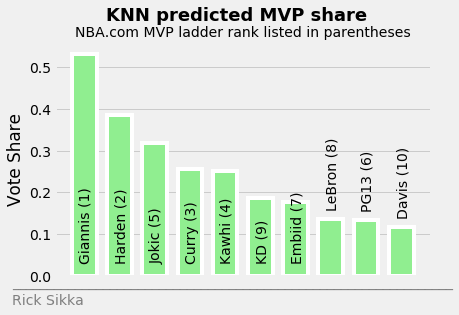

In [284]:
plt.style.use('fivethirtyeight')

knn, ax = plt.subplots()

ax.bar(x_knn, knnData, width = .7, edgecolor = 'white', color = 'lightgreen', linewidth = 4, label = 'Predicted')

labels = knnNames

rects = ax.patches
for rect, label in zip(rects, labels):
    if rect.get_x() > 6:
        ax.text(rect.get_x() + rect.get_width() / 1.75, rect.get_height() + .02, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
    elif rect.get_x() <= 6:
        height = .03
        ax.text(rect.get_x() + rect.get_width() / 1.75, height, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
        
knn.suptitle("KNN predicted MVP share", weight = 'bold', size = 18, y = 1.005)
ax.set_title("NBA.com MVP ladder rank listed in parentheses", size = 14, fontname = 'Rockwell')
ax.xaxis.set_visible(False)
ax.set_ylabel("Vote Share")

knn.text(x = -0.02, y = 0.03,
    s = '_______________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

knn.text(x = -0.02, y = -.03,
    s = 'Rick Sikka                     ',
    fontsize = 14, fontname = 'DejaVu Sans', color = 'grey', horizontalalignment='left')

knn.savefig('knn.png', dpi = 400, bbox_inches = 'tight')

### Deep Neural Network

In [285]:
dnnPredict = dnn.predict(dfCurrentPredict)
dnnPredict = dnnPredict.tolist()

for (i, j) in zip(dfCurrentNames, dnnPredict):
    print(i, j)

Giannis (1) 0.5308882541242831
Harden (2) 0.4981903737147834
Curry (3) 0.2529571349865109
Kawhi (4) 0.32422060363959354
Jokic (5) 0.3499368570948033
PG13 (6) 0.27774069262461926
Embiid (7) 0.27598625541230576
LeBron (8) 0.07790166772840272
KD (9) 0.38428470003732124
Davis (10) 0.27020386705783456


In [286]:
dnnListUnsorted = [[i, j] for i, j in zip(dfCurrentNames, dnnPredict)]
dnnDataUnsorted = [row[1] for row in dnnListUnsorted]
dnnList = sorted(dnnListUnsorted, key = itemgetter(1), reverse = True)

dnnData = [row[1] for row in dnnList]
dnnNames = [row[0] for row in dnnList]
print(dnnList)

x_dnn = np.arange(len(dnnData))

[['Giannis (1)', 0.5308882541242831], ['Harden (2)', 0.4981903737147834], ['KD (9)', 0.38428470003732124], ['Jokic (5)', 0.3499368570948033], ['Kawhi (4)', 0.32422060363959354], ['PG13 (6)', 0.27774069262461926], ['Embiid (7)', 0.27598625541230576], ['Davis (10)', 0.27020386705783456], ['Curry (3)', 0.2529571349865109], ['LeBron (8)', 0.07790166772840272]]


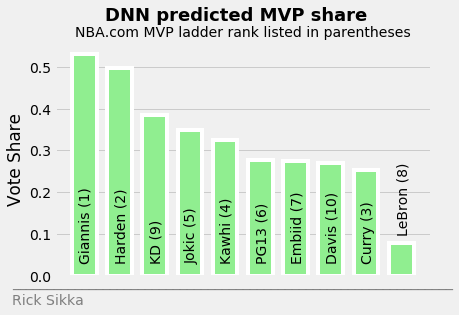

In [287]:
plt.style.use('fivethirtyeight')

dnn, ax = plt.subplots()

ax.bar(x_dnn, dnnData, width = .7, edgecolor = 'white', color = 'lightgreen', linewidth = 4, label = 'Predicted')

labels = dnnNames

rects = ax.patches
for rect, label in zip(rects, labels):
    if rect.get_x() > 8:
        ax.text(rect.get_x() + rect.get_width() / 1.75, rect.get_height() + .02, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
    elif rect.get_x() <= 8:
        height = .03
        ax.text(rect.get_x() + rect.get_width() / 1.75, height, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
        
dnn.suptitle("DNN predicted MVP share", weight = 'bold', size = 18, y = 1.005)
ax.set_title("NBA.com MVP ladder rank listed in parentheses", size = 14, fontname = 'Rockwell')
ax.xaxis.set_visible(False)
ax.set_ylabel("Vote Share")

dnn.text(x = -0.02, y = 0.03,
    s = '_______________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

dnn.text(x = -0.02, y = -.03,
    s = 'Rick Sikka                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')

dnn.savefig('dnn.png', dpi = 400, bbox_inches = 'tight')